### HEAD

In [209]:
import math
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import operator

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from functools import reduce
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from typing import List, Callable, Tuple, Union
from dtaidistance import dtw
from datetime import timedelta, datetime
from src import plot_time_series


import warnings
warnings.filterwarnings("ignore")

### Params

In [403]:
metric_name = "rto"
id_field_name = "CityName"
time_series_field = "dt"
number_of_neighbours = 3
test_units = ['Пенза', 'Уфа', 'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск']
alpha = 0.05
cuped_time = 28

In [146]:
# введем переменные с датами
start_of_test = "2022-04-07"
days_for_knn = 70
days_for_validation = 28
days_for_test = 28

end_of_test = (datetime.strptime(start_of_test, "%Y-%m-%d") + timedelta(days=days_for_test)).strftime("%Y-%m-%d")
start_of_validation = (datetime.strptime(start_of_test, "%Y-%m-%d") + timedelta(days=-days_for_validation)).strftime("%Y-%m-%d")
start_of_knn = (datetime.strptime(start_of_validation, "%Y-%m-%d") + timedelta(days=-days_for_knn)).strftime("%Y-%m-%d")

print(f"Подбор групп: с {start_of_knn} по {start_of_validation}")
print(f"Валидация: с {start_of_validation} по {start_of_test}")
print(f"Тест: с {start_of_test} по {end_of_test}")

Подбор групп: с 2021-12-30 по 2022-03-10
Валидация: с 2022-03-10 по 2022-04-07
Тест: с 2022-04-07 по 2022-05-05


In [147]:
path = r"C:\Users\repin\Desktop\GitHub\TestLab\development\test-data.csv"
df = pd.read_csv(path)

In [148]:
# добавим данные по месяцу и дате в удобном формате
df['month'] = df['Date'].apply(lambda x: x[:7])
df['dt'] = df['Date'].apply(lambda x: x[:10])

In [149]:
# данные для обучения knn
knn_data = df[
    (df['dt'] >= start_of_knn) & (df['dt'] < start_of_validation)
    & (df['OrderSource'] == 'web') & (df['Category'] == 'пицца')
    ]
knn_data.shape

(17899, 14)

##### Обработка KNN данных

In [150]:
knn_data = knn_data[["dt", "CityName", "rto"]]
knn_data = knn_data[~knn_data["CityName"].isin(["Москва", "Санкт-Петербург"])]

In [151]:
knn_data.head()

,dt,CityName,rto
7,2022-01-01,Абакан,39132.1742
19,2022-01-01,Абинск,8357.3700
30,2022-01-01,Азов,9856.7700
39,2022-01-01,Аксай Россия,4148.3400
51,2022-01-01,Александров,8407.3500


In [155]:
knn_data_pivot = knn_data.pivot_table(values=metric_name, columns=time_series_field, index=id_field_name)

In [156]:
cols = list(knn_data_pivot.columns)

wrong_cities = []
for i in cols:
    one_row = knn_data_pivot.loc[:, i]
    if one_row.isnull().values.any():
        all_cities = list(one_row[one_row.isnull().values].index)
        for i in all_cities:
            if i not in wrong_cities:
                wrong_cities.append(i)

In [157]:
# оставляем города, включая мск и спб, кроме тех, где есть пропуски в данных
test_wo_denied_ = [i for i in set(knn_data[id_field_name]) if i not in wrong_cities]

In [158]:
len(test_wo_denied_)

232

In [159]:
knn_data_clean = knn_data[knn_data[id_field_name].isin(test_wo_denied_)]

In [160]:
knn_data.head()

,dt,CityName,rto
7,2022-01-01,Абакан,39132.1742
19,2022-01-01,Абинск,8357.3700
30,2022-01-01,Азов,9856.7700
39,2022-01-01,Аксай Россия,4148.3400
51,2022-01-01,Александров,8407.3500


### FUNCs

In [161]:
def get_scaled_data(data: pd.DataFrame, metric_name: str) -> pd.DataFrame:
    """
    Метод для масштабирования данных. Используется StandardScaler

    Args:
        data (pd.DataFrame): датафрейм с датами, юнитами и метрикой
        metric_name (str): наменование столбца с метрикой

    Raises:
        KeyError: В случае, если наименование столбца с метрикой указано
        неверно, бросается исключение

    Returns:
        pd.DataFrame: исходный датафрейм + масштабированная метрика
    """
    try:
        scaled_metric = StandardScaler().fit_transform(data[[metric_name]])
    except KeyError:
        raise KeyError(f"Frame data does not contain the field with name {metric_name}")
    data[f"scaled_{metric_name}"] = scaled_metric
    return data

In [162]:
knn_pre_exp_clean_scld = get_scaled_data(knn_data_clean, metric_name)

In [163]:
knn_pre_exp_clean_scld.head()

,dt,CityName,rto,scaled_rto
7,2022-01-01,Абакан,39132.1742,0.026246
19,2022-01-01,Абинск,8357.3700,-0.568868
30,2022-01-01,Азов,9856.7700,-0.539873
39,2022-01-01,Аксай Россия,4148.3400,-0.650261
51,2022-01-01,Александров,8407.3500,-0.567902


In [165]:
def get_vectors(data: pd.DataFrame, metric_name: str, id_field_name: str) -> Tuple[dict, dict]:
    """
    Преобразует метрику из датафрейма в векторный вид

    Args:
        data (pd.DataFrame): датафрейм c масштабированной метрикой
        metric_name (str): наименование столбца с масштабированной метрикой
        id_field_name (str): наименование столбца с юнитом

    Returns:
        Tuple[dict, dict]:
            dict0 - словарь с наименованием юнита в ключе и вектором в значении
            dict1 - словарь с индексом юнита в ключе и наименованием юнита в значении
    """
    data_vec = data.groupby(id_field_name).agg({f"scaled_{metric_name}": list}).reset_index()
    data_vec[f"{metric_name}_array"] = [np.array(i) for i in data_vec[f"scaled_{metric_name}"]]
    keys = data_vec[id_field_name].tolist()
    vals = data_vec[f"{metric_name}_array"].tolist()
    return dict(zip(keys, vals)), dict(zip([i for i in range(0, len(keys))], keys))

In [166]:
knn_vectors, ids_dict = get_vectors(knn_pre_exp_clean_scld, metric_name, id_field_name)

In [107]:
def get_k_neighbours(
    id: str, vectors: dict, number_of_neighbours: int, algorithm='auto'
) -> dict:
    """
    Возвращает k ближайших соседей для одного заданного юнита

    Args:
        id (str): идентификатор юнита
        vectors (dict): словарь с наименованием юнита в ключе и вектором метрики в значении 
        number_of_neighbours (int): количество ближайших соседей для поиска
        algorithm (str, optional): алгорит подбора соседей. Defaults to 'auto'.

    Returns:
        dict: словарь с индексами юнитов в ключах и расстоянием в значении
    """
    def get_knn(vectors):
        vector_arrays = [list(i) for i in vectors.values()]
        return NearestNeighbors(number_of_neighbours, algorithm=algorithm).fit(vector_arrays)        

    def get_vector(vectors, id):
        return vectors[id].reshape(1, -1)

    def flatten_neighbour_list(distance, ids):
        dist_list, nb_list = distance.tolist(), ids.tolist()
        return dist_list[0], nb_list[0]

    knn = get_knn(vectors)
    vector = get_vector(vectors, id)
    dist, nb_indexes = knn.kneighbors(vector, number_of_neighbours, return_distance=True)
    return_dist, return_nb_indexes = flatten_neighbour_list(dist, nb_indexes)
    return dict(zip(return_nb_indexes, return_dist))

In [169]:
def find_nearest_neighbors_dtw_dict(data_dict: dict, target_id: str, n_neighbors=1):
    """
    Находит ближайших соседей по расстоянию DTW для заданного временного ряда.

    :param data_dict: словарь, где ключи — идентификаторы наблюдений, значения — вектора временных рядов.
    :param target_id: идентификатор временного ряда, для которого ищутся соседи.
    :param n_neighbors: количество ближайших соседей, которые нужно вернуть.
    :return: словарь, где ключи — идентификаторы ближайших соседей, значения — расстояния DTW.
    """
    target_vector = data_dict[target_id]
    distances = {}
    for key, vector in data_dict.items():
        if key != target_id:
            distances[key] = dtw.distance(vector, target_vector)    
    sorted_distances = sorted(distances.items(), key=lambda item: item[1])
    nearest_neighbors = dict(sorted_distances[:n_neighbors])

    return nearest_neighbors

In [170]:
get_k_neighbours("Орск", knn_vectors, 3)

{152: 0.0, 190: 0.7594478829269001, 77: 0.7652548710999338}

In [173]:
ids_dict[190], ids_dict[77]

('Стерлитамак', 'Кириши')

In [171]:
find_nearest_neighbors_dtw_dict(knn_vectors, "Орск", 3)

{'Кронштадт': 0.5387766979939548,
 'Прокопьевск': 0.5431580296880775,
 'Горно-Алтайск': 0.5700736014197976}

In [198]:
def get_all_neighbours_eucl(
    knn_vectors: dict, ids_dict: dict, test_units: List[str], number_of_neighbours: int
) -> dict:
    """
    Возвращает словарь с ближайшими соседями для всех, поданных на вход юнитов

    Args:
        knn_vectors (dict): словарь с наименованием юнита в ключе и вектором в значении
        ids_dict (dict): словарь с индексом юнита в ключе и наименованием юнита в значении
        test_units (List[str]): список юнитов из тестовой группы
        number_of_neighbours (int): количество ближайших соседей

    Returns:
        dict: словарь с наменованием юнита в ключе и списком соседей в значении
    """
    result_ids = {
        i:[ids_dict[j] for j in get_k_neighbours(i, knn_vectors, number_of_neighbours + 1) if ids_dict[j] != i]
        for i in test_units
    }
    return result_ids

In [202]:
def get_all_neighbours_dtw(knn_vectors: dict, number_of_neighbours: int, test_units: List[str]):
    """_summary_

    Args:
        knn_vectors (dict): _description_
        number_of_neighbours (int): _description_
        test_units (List[str]): _description_
    """
    res = {
        i:[j for j in find_nearest_neighbors_dtw_dict(knn_vectors, i, number_of_neighbours)] for i in test_units
    }
    return res

In [203]:
all_neighbours_dtw = get_all_neighbours_dtw(knn_vectors, number_of_neighbours, test_units)
all_neighbours_dtw

{'Пенза': ['Рязань', 'Чита', 'Смоленск'],
 'Уфа': ['Оренбург', 'Томск', 'Волгоград'],
 'Курск': ['Березники', 'Саранск', 'Абакан'],
 'Нижний Тагил': ['Бердск', 'Брянск', 'Ухта'],
 'Новокуйбышевск': ['Альметьевск', 'Сергиев Посад', 'Красное Село'],
 'Орск': ['Кронштадт', 'Прокопьевск', 'Горно-Алтайск']}

In [200]:
all_neighbours_eucl = get_all_neighbours_eucl(knn_vectors, ids_dict, test_units, number_of_neighbours)
all_neighbours_eucl

{'Пенза': ['Чита', 'Смоленск', 'Рязань'],
 'Уфа': ['Оренбург', 'Томск', 'Ижевск'],
 'Курск': ['Магнитогорск', 'Саранск', 'Волжский'],
 'Нижний Тагил': ['Брянск', 'Бердск', 'Вологда'],
 'Новокуйбышевск': ['Альметьевск', 'Красное Село', 'Верхняя Пышма'],
 'Орск': ['Стерлитамак', 'Кириши', 'Горно-Алтайск']}

In [204]:
def get_test_control_val_groups(neighbours_dict: dict, test_units: List[str]) -> dict:
    """
    Формирует словарь со списками тестовых и контрольных юнитов в значениях словаря

    Args:
        neighbours_dict (dict): словарь с наменованием юнита в ключе и списком соседей в значении

    Returns:
        dict: итоговый словарь {test_units: [str], control_units: [str]}
    """
    test_units = list(neighbours_dict.keys())
    control_units = [[j for j in i if j not in test_units][0] for i in neighbours_dict.values()]
    return dict(
        test_units=test_units,
        control_units=control_units,
    )

In [207]:
all_groups_dtw = get_test_control_val_groups(all_neighbours_dtw, test_units)
all_groups_dtw

{'test_units': ['Пенза',
  'Уфа',
  'Курск',
  'Нижний Тагил',
  'Новокуйбышевск',
  'Орск'],
 'control_units': ['Рязань',
  'Оренбург',
  'Березники',
  'Бердск',
  'Альметьевск',
  'Кронштадт']}

In [208]:
all_groups_eucl = get_test_control_val_groups(all_neighbours_eucl, test_units)
all_groups_eucl

{'test_units': ['Пенза',
  'Уфа',
  'Курск',
  'Нижний Тагил',
  'Новокуйбышевск',
  'Орск'],
 'control_units': ['Чита',
  'Оренбург',
  'Магнитогорск',
  'Брянск',
  'Альметьевск',
  'Стерлитамак']}

### VIZ

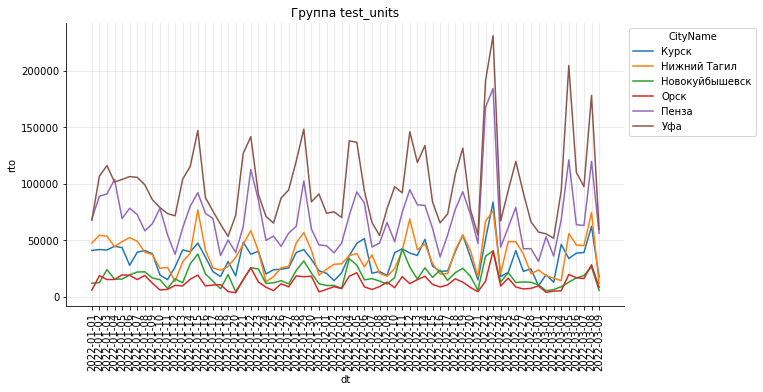

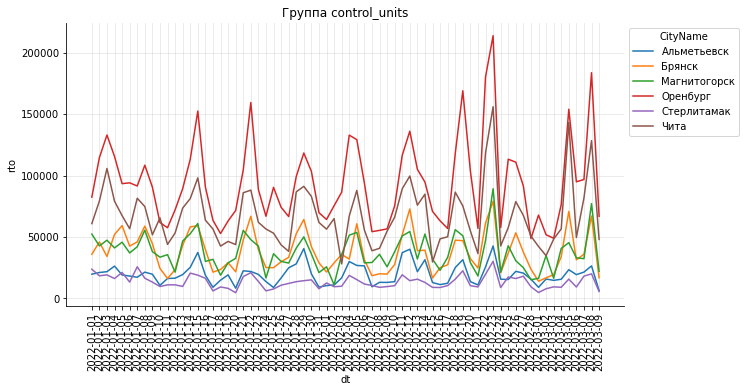

In [210]:
for i in all_groups_eucl.keys():

    plot_time_series(
        df=knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_eucl[i])],
        metric_name=metric_name,
        grouped_column=id_field_name,
        time_series_name=time_series_field,
        title=f"Группа {i}"
    )

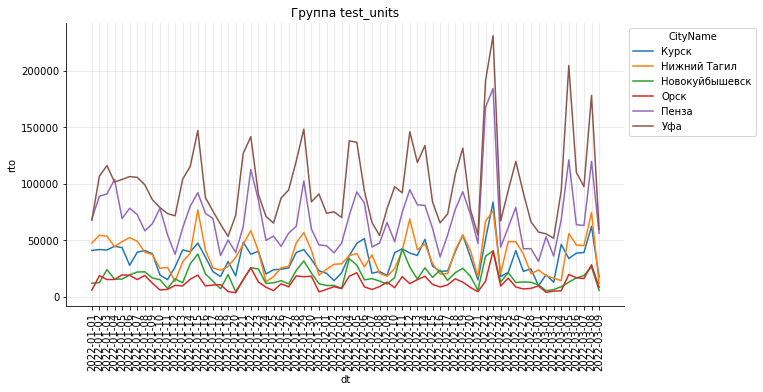

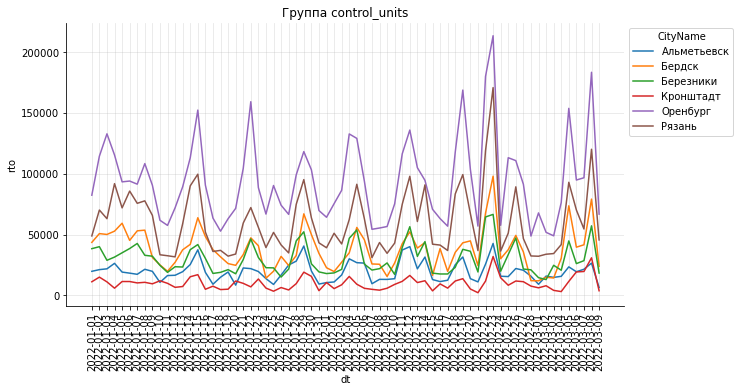

In [211]:
for i in all_groups_dtw.keys():

    plot_time_series(
        df=knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw[i])],
        metric_name=metric_name,
        grouped_column=id_field_name,
        time_series_name=time_series_field,
        title=f"Группа {i}"
    )

In [217]:
test_group_std = np.std(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw["test_units"])][metric_name])
control_group_std_dtw = np.std(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw["control_units"])][metric_name])
control_group_std_eucl = np.std(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_eucl["control_units"])][metric_name])
test_group_std, control_group_std_dtw, control_group_std_eucl

(36698.28677281828, 34922.49163458264, 34498.231891458316)

In [218]:
test_group_mean = np.mean(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw["test_units"])][metric_name])
control_group_mean_dtw = np.mean(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_dtw["control_units"])][metric_name])
control_group_mean_eucl = np.mean(knn_data_clean[knn_data_clean[id_field_name].isin(all_groups_eucl["control_units"])][metric_name])
test_group_mean, control_group_mean_dtw, control_group_mean_eucl

(44837.07237916666, 42158.909479166665, 45061.26505416668)

In [219]:
def plot_ci(difference, point_estimation, ci):
    ax = sns.kdeplot(difference, label='kde статистики', fill=False, color='crimson')
    kdeline = ax.lines[0]
    plt.plot([point_estimation], [0], 'o', c='k', markersize=6, label='точечная оценка')
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    ax.vlines(point_estimation, 0, np.interp(point_estimation, xs, ys), color='crimson', ls=':')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    ax.fill_between(xs, 0, ys, where=(ci[0] <= xs) & (xs <= ci[1]), interpolate=True, facecolor='crimson', alpha=0.2)
    plt.grid(alpha=0.3)
    plt.title('Доверительный интервал')
    plt.legend()
    plt.show()

In [220]:
def get_percentile_ci(bootstrap_stats: List[float], alpha: float=0.05):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def get_normal_ci(
    bootstrap_stats: Union[np.array, List], pe: float, alpha: float = 0.05
) -> Tuple[float, float]:
    """
    Строит нормальный доверительный интервал.

    args:
        bootstrap_stats - массив значений посчитанной метрики,
        pe - точечная оценка (рассчитывается на исходных данных)

    return:
        left, right - левая и правая границы доверительного интервала
    """
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = pe - z * se, pe + z * se
    return left, right

In [ ]:
def plot_pvalue_distribution(pvalues_aa: np.array, pvalues_ab: np.array, alpha=0.05) -> None:
    """
    Рисует графики распределения p-value.
    Тестирование метода в playbooks/development/dev-plot-improvement.ipynb

    args:
        pvalues_aa - массив результатов оценки АА теста,
        pvalues_ab - массив результатов оценки АВ теста
    return:
        None
    """
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    estimated_second_type_error = np.mean(pvalues_ab >= alpha)
    y_one = estimated_first_type_error
    y_two = 1 - estimated_second_type_error
    X = np.linspace(0, 1, 1000)
    Y_aa = [np.mean(pvalues_aa < x) for x in X]
    Y_ab = [np.mean(pvalues_ab < x) for x in X]
    plt.plot(X, Y_aa, label='A/A')
    plt.plot(X, Y_ab, label='A/B')
    plt.plot(
        [alpha, alpha],
        [0, 1],
        '-.k',
        alpha=0.8,
        label='Мощность',
        color='g'
    )
    plt.plot([0, alpha], [y_one, y_one], '--k', alpha=0.8)
    plt.plot([0, alpha], [y_two, y_two], '--k', alpha=0.8)
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8, label='Распределение ошибки I рода')
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid(color='grey', linestyle='--', linewidth=0.2)
    plt.show()

### BOOTSTRAP

In [376]:
def bootstrap(
    control_group: np.array,
    test_group: np.array,
    metric_func: Callable,
    bootstrap_group_length: int,
    effect: int,
    alpha: float = 0.05,
    n_iter: int = 10_000,
    verbose: bool = False
):
    
    def _help_function(func: Callable, group: np.ndarray) -> Callable:
        return func(group)
    difference_aa = np.zeros(n_iter)
    difference_ab = np.zeros(n_iter)
    #p_value_aa_res_tt = np.zeros(n_iter)
    #p_value_ab_res_tt = np.zeros(n_iter)
    for i in range(n_iter):
        
        random_values_control = np.random.choice(control_group, bootstrap_group_length, True)
        random_values_test = np.random.choice(test_group, bootstrap_group_length, True)
        random_values_test_with_eff = np.random.choice(test_group + effect, bootstrap_group_length, True)
        
        control_metric = _help_function(metric_func, random_values_control)
        test_metric = _help_function(metric_func, random_values_test)
        test_metric_with_eff = _help_function(metric_func, random_values_test_with_eff)
        
        difference_aa[i] = test_metric - control_metric
        difference_ab[i] = test_metric_with_eff - control_metric
        
        
        #_, p_value_aa = stats.ttest_ind(random_values_test, random_values_control)
        #p_value_aa_res_tt[i] = p_value_aa
        #_, p_value_ab = stats.ttest_ind(random_values_test_with_eff, random_values_control)
        #p_value_aa_res_tt[i] = p_value_ab

    # Расчет точечных оценок
    point_estimation_aa = (
        _help_function(metric_func, test_group) - _help_function(metric_func, control_group)
    )
    point_estimation_ab = (
        _help_function(metric_func, test_group + effect) - _help_function(metric_func, control_group)
    )
    
    # Считаем p-value
    adj_diffs_aa = difference_aa - point_estimation_aa
    adj_diffs_ab = difference_ab - point_estimation_ab
    false_positive_aa = np.sum(np.abs(adj_diffs_aa) >= np.abs(point_estimation_aa))
    false_positive_ab = np.sum(np.abs(adj_diffs_ab) >= np.abs(point_estimation_ab))
    p_value_aa_boot = false_positive_aa / n_iter
    p_value_ab_boot = false_positive_ab / n_iter

    # Расчет доверительных интервалов
    ci_aa = get_percentile_ci(difference_aa)
    ci_ab = get_percentile_ci(difference_ab)
    
    has_effect_aa = not (ci_aa[0] < 0 < ci_aa[1])
    has_effect_ab = not (ci_ab[0] < 0 < ci_ab[1])
    
    if verbose:
        print("A/A тест")
        print(f'Значение метрики изменилось на: {point_estimation_aa:0.5f}')
        print(
            f'{((1 - alpha) * 100)}% доверительный интервал: '
            f'({ci_aa[0]:0.5f}, {ci_aa[1]:0.5f})'
        )
        print(f'Отличия статистически значимые: {has_effect_aa}')
        print(f"p-value from bootstrap is: {p_value_aa_boot}")
        plot_ci(difference_aa, point_estimation_aa, ci_aa)
        print("------------------")
        print("A/B тест")
        print(f'Значение метрики изменилось на: {point_estimation_ab:0.5f}')
        print(
            f'{((1 - alpha) * 100)}% доверительный интервал: '
            f'({ci_ab[0]:0.5f}, {ci_ab[1]:0.5f})'
        )
        print(f'Отличия статистически значимые: {has_effect_ab}')
        print(f"p-value from bootstrap is: {p_value_ab_boot}")
        plot_ci(difference_ab, point_estimation_ab, ci_ab)
    else:
        return dict(
            aa_test=has_effect_aa,
            ab_test=has_effect_ab,
            pe_aa=point_estimation_aa,
            pe_ab=point_estimation_ab,
            ci_aa=ci_aa,
            ci_ab=ci_ab,
            #p_value_ab_tt=p_value_ab_res_tt,
            #p_value_aa_tt=p_value_aa_res_tt,
            p_value_aa_boot=p_value_aa_boot,
            p_value_ab_boot=p_value_ab_boot
        )

### VAL

In [367]:
# данные для валидации
validation_data = df[
    (df['dt'] >= start_of_validation) & (df['dt'] < start_of_test)
    & (df['OrderSource'] == 'web') & (df['Category'] == 'пицца')
    ]
validation_data.shape

(7352, 14)

In [368]:
values_control_val = np.array(validation_data[validation_data[id_field_name].isin(all_groups_dtw["control_units"])][metric_name])
values_test_val = np.array(validation_data[validation_data[id_field_name].isin(all_groups_dtw["test_units"])][metric_name])
n = len(np.array(validation_data[validation_data[id_field_name].isin(all_groups_dtw["test_units"])][metric_name]))
n

168

In [ ]:
# t-test на временных рядах
eff = 3000
res_dict = bootstrap(
        values_control_val,
        values_test_val,
        np.mean,
        n,
        eff
    )

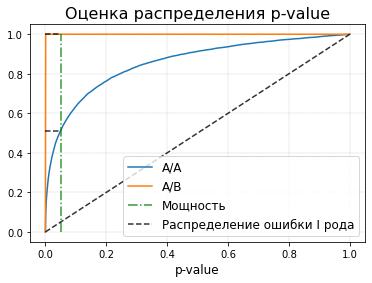

In [377]:
plot_pvalue_distribution(res_dict["p_value_aa_tt"], res_dict["p_value_ab_tt"])

In [378]:
bootstrap(
    values_control_val,
    values_test_val,
    np.mean,
    n,
    3000,
    verbose=False
)

{'aa_test': False,
 'ab_test': True,
 'pe_aa': 3690.4523666666646,
 'pe_ab': 6690.452366666665,
 'ci_aa': (-2825.4778830208325, 10266.245453020829),
 'ci_ab': (175.4068146874995, 13329.34173572917),
 'p_value_aa_boot': 0.2792,
 'p_value_ab_boot': 0.0464}

A/A тест
Значение метрики изменилось на: 3690.45237
95.0% доверительный интервал: (-2825.59740, 10354.13956)
Отличия статистически значимые: False
p-value from bootstrap is: 0.2738


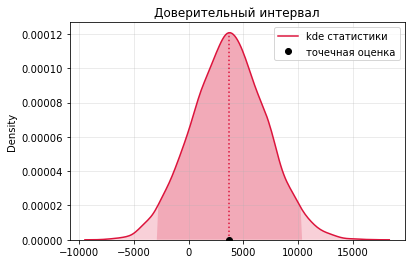

------------------
A/B тест
Значение метрики изменилось на: 6690.45237
95.0% доверительный интервал: (49.52126, 13326.82923)
Отличия статистически значимые: True
p-value from bootstrap is: 0.0472


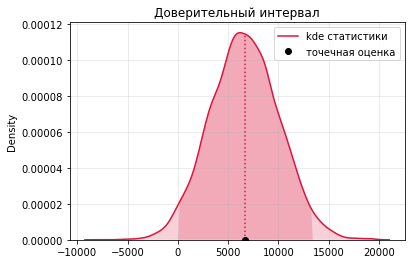

In [379]:
bootstrap(
    values_control_val,
    values_test_val,
    np.mean,
    n,
    3000,
    verbose=True
)

In [380]:
pval_aa = []
pval_ab = []
eff = 2950
for i in tqdm(range(1000)):
    res_dict = bootstrap(
        values_control_val,
        values_test_val,
        np.mean,
        n,
        eff
    )
    pval_aa.append(res_dict["p_value_aa_boot"])
    pval_ab.append(res_dict["p_value_ab_boot"])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [382]:
get_normal_ci(pval_aa, np.mean(pval_aa))

(0.2627465729177877, 0.2797626270822122)

In [383]:
get_normal_ci(pval_ab, np.mean(pval_ab))

(0.043795638997108165, 0.052190761002891835)

### CUPED

In [ ]:
def _calculate_theta(*, y_prepilot: np.array, y_pilot: np.array) -> float:
    """
    Вычисляем Theta.

    args:
        y_pilot - значения метрики во время пилота,
        y_prepilot - значения ковариант (той же самой метрики) на препилоте
    return:
        theta - значение коэффициента тета
    """
    covariance = np.cov(y_prepilot.astype(float), y_pilot.astype(float))[0, 1]
    variance = np.var(y_prepilot)
    theta = covariance / variance
    return theta

In [384]:
def calculate_cuped_metric(
    df_history, df_experiment, target_metric_name: str, id_field_name: str, theta: float = None
) -> pd.DataFrame:
    """
    Вычисляет коварианту и преобразованную метрику cuped.

    args:
        df - pd.DataFrame, датафрейм с данными по пользователям,
        метрикам (нормализованной ключевой метрикой) и стратами с разметкой:
            1) на контроль и пилот (A/B/C..., где A-контроль) - столбец group,
            2) пред-экспериментальный и экспериментальный периоды
            (pilot/prepilot) - столбец period,
    return:
        res - датафрейм
    """
    if df_history is None:
        raise (
            'Для применения CUPED используются исторические или прогнозные данные. '
            'Необходимо задать аргумент df_history.'
        )
    prepilot_period = (
        df_history[df_history['period'] == 'history']
        .sort_values(id_field_name)
    )
    pilot_period = (
        df_experiment[df_experiment['period'] == 'pilot']
        .sort_values(id_field_name)
    )
    if theta is None:
        theta = _calculate_theta(
            y_prepilot=np.array(prepilot_period[target_metric_name]),
            y_pilot=np.array(pilot_period[target_metric_name])
            )
    res = pd.merge(
        prepilot_period,
        pilot_period,
        how='inner',
        on=id_field_name,
        suffixes=["_prepilot", "_pilot"]
    )
    cols = list(prepilot_period.columns)
    print(f'Theta is: {theta}', )
    res[f'{target_metric_name}_cuped'] = (
        res[f"{target_metric_name}_pilot"] - theta * res[f'{target_metric_name}_prepilot']
    )
    return res

In [387]:
def check_weekday_or_weekend(date):
    given_date = datetime.strptime(date, '%Y-%m-%d')
    day_of_week = (given_date.weekday() + 1)
    return day_of_week
date = '2024-07-01'
check_weekday_or_weekend(date)

1

In [412]:
def sort_merge_for_cuped(pre_pilot_df: pd.DataFrame, pilot_df: pd.DataFrame, id_field_name: str, cuped_time: int):
    pre_pilot_df["weekday"] = pre_pilot_df[time_series_field].apply(lambda x: check_weekday_or_weekend(x))
    pilot_df["weekday"] = pilot_df[time_series_field].apply(lambda x: check_weekday_or_weekend(x))
    dates_for_lin = sorted(list(set(pre_pilot_df[time_series_field].values)))[-cuped_time:]
    print(len(dates_for_lin))
    pre_pilot_df = pre_pilot_df[
        pre_pilot_df[time_series_field].isin(dates_for_lin) & 
        pre_pilot_df[id_field_name].isin(set(pilot_df[id_field_name].values))
    ]
    print(pilot_df.shape, pre_pilot_df.shape)
    
    pilot_df_sort = pilot_df.sort_values([id_field_name, "weekday"])
    pre_pilot_df_sort = pre_pilot_df.sort_values([id_field_name, "weekday"])
    
    pilot_df_sort["row_number"] = [i for i in range(0, len(pilot_df_sort))]
    pre_pilot_df_sort["row_number"] = [i for i in range(0, len(pre_pilot_df_sort))]
    
    pilot_df_sort["period"] = "pilot"
    pre_pilot_df_sort["period"] = "history"
    return pilot_df_sort, pre_pilot_df_sort

In [413]:
validation_data.shape, knn_data_clean.shape

((7352, 15), (15776, 5))

In [414]:
pilot_df_sort, pre_pilot_df_sort = sort_merge_for_cuped(
    knn_data_clean,
    validation_data,
    id_field_name,
    cuped_time
)

28
(7352, 15) (6496, 5)


In [ ]:
pilot_df_sort[pilot_df_sort]

In [405]:
pilot_df_sort.shape, pre_pilot_df_sort.shape

((7352, 17), (6496, 7))

In [396]:
cols = ['dt', 'CityName', 'rto', 'weekday', 'row_number', 'period']

In [399]:
pilot_df_sort[cols].head(2)

,dt,CityName,rto,weekday,row_number,period
218384,2022-03-14,Абакан,15879.7884,1,0,pilot
239700,2022-03-21,Абакан,13803.6073,1,1,pilot


In [400]:
pre_pilot_df_sort[cols].head(2)

,dt,CityName,rto,weekday,row_number,period
175955,2022-02-28,Абакан,17391.7429,1,0,history
196999,2022-03-07,Абакан,30868.6000,1,1,history


In [ ]:
calculate_cuped_metric(
    pre_pilot_df_sort[cols],
    pilot_df_sort[cols],
    metric_name,
    id_field_name
)

In [ ]:
def multitest_correction(
    *, list_of_pvals: List, alpha: float = 0.05, method: str = 'holm', **kwargs
) -> None:
    """
    Корректировка p-value для множественной проверки гипотез.

    args:
        list_of_pvals - массив рассчитанных p-value значений
        alpha - уровень ошибки первого рода
        method - метод поправки, default: 'holm', подробнее по ссылке
            https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
    """
    decision, adj_pvals, sidak_aplha, bonf_alpha = stats.multitest.multipletests(
        pvals=list_of_pvals, alpha=alpha, method=method)
    return dict(
        decision=list(decision),
        adjusted_pvals=[np.round(i, 10) for i in adj_pvals],
        sidak_aplha=sidak_aplha,
        bonf_alpha=bonf_alpha
    )